## <font color=blue>Import needed modules</font>

In [1]:
!pip install tensorflow -q     #already available in Google Colab
!pip install -q -U keras-tuner  #will need to install BUT just once on Google Colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [2]:
#general libraries needed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#TensorFlow requirements
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

#scikit learn imports
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_absolute_error,  classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.dummy import DummyClassifier

# Smote
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

from imblearn.pipeline import Pipeline as SPL  #

#give yourself the opportunity to visualize the pipeline and models
from sklearn import set_config
set_config(display='diagram')

## <font color=blue>Function Definitions

In [3]:
#function to verify the existence of a file in the current working directory and download it if not
import os,urllib, urllib.request, sys, tarfile
def downloadDataResource(file, sourcePath, compressed=None):
    if not os.path.isfile(file):
        try:
            urllib.request.urlretrieve(sourcePath+(compressed if compressed else file),(compressed if compressed else file))
            print("Downloaded", (compressed if compressed else file) )
            if compressed:
                ucomp = tarfile.open(compressed)
                ucomp.extractall()
                ucomp.close()
                print("File uncompressed.")
        except:
            print("ERROR: File", (compressed if compressed else file), "not found. Data source missing.")
    else:
        print("Data resource", file, "already downloaded.")

In [4]:
#function provided that plots the learning curve for neural networks
def nn_plot_learning_curve( history ):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    ymin, ymax = [], []
    for x in history.history.keys():
        ymax.append( max(history.history[x]))
        ymin.append( min(history.history[x]))
    plt.gca().set_ylim(min(ymin)*.95, max(ymax)*1.05)
    plt.xlabel("EPOCHS")
    plt.show()

In [5]:
def nn_plot_learning_curve_2(history):
    df = pd.DataFrame(history.history)[['accuracy','val_accuracy']]

    # Plot Accuracy and val accuracy curves
    df.plot(figsize=(8, 5))
    plt.grid(True)

    # Set y-axis limits with margin
    ymin = df.min().min()
    ymax = df.max().max()
    plt.gca().set_ylim(ymin * 0.95, ymax * 1.05)

    plt.xlabel("EPOCHS")
    plt.ylabel("ACCURACY")
    plt.title("Accuracy vs Epochs")
    plt.show()


In [6]:
def nn_plot_learning_curve_3(history):
#
    df = pd.DataFrame(history.history)[['loss','val_loss']]

    # Plot Loss and Val Loss  curves
    df.plot(figsize=(8, 5))
    plt.grid(True)

    # Set y-axis limits with margin
    ymin = df.min().min()
    ymax = df.max().max()
    plt.gca().set_ylim(ymin * 0.95, ymax * 1.05)

    plt.xlabel("EPOCHS")
    plt.ylabel("LOSS")
    plt.title("Loss vs Epochs")
    plt.show()

## <font color=blue>Source Data

In [7]:
#create a dataframe with the data from the CSV file
path = "https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/main/chpt10/"
filename = "IndegoRides.csv"
downloadDataResource(filename, path)

data = pd.read_csv(filename)

Downloaded IndegoRides.csv


## <font color=blue>Prepare the data set

### Take a look at the data


In [8]:
data.head()

,Date,BikeType,TripType,AvgDuration,NumTrips,AvgHumidity,MinTemp,MaxTemp,Windy,Rain,Snow
0,2021-11-17,Standard,Round Trip,32,55,67,36.93,64.18,0,0,0
1,2019-01-30,Standard,Round Trip,33,22,64,11.79,37.98,0,1,1
2,2019-11-11,Standard,Round Trip,36,67,67,35.91,65.48,0,0,0
3,2022-02-14,Standard,Round Trip,17,23,53,15.30,32.68,0,0,0
4,2020-06-11,Electric,Round Trip,78,74,81,72.91,85.19,0,1,0


In [9]:
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9750 entries, 0 to 9749
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         9750 non-null   object 
 1   BikeType     9750 non-null   object 
 2   TripType     9750 non-null   object 
 3   AvgDuration  9750 non-null   int64  
 4   NumTrips     9750 non-null   int64  
 5   AvgHumidity  9750 non-null   int64  
 6   MinTemp      9750 non-null   float64
 7   MaxTemp      9750 non-null   float64
 8   Windy        9750 non-null   int64  
 9   Rain         9750 non-null   int64  
 10  Snow         9750 non-null   int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 838.0+ KB


In [10]:
# looking at missing values
missing_value_sum = data.isnull().sum()
missing_value_sum


,0
Date,0
BikeType,0
TripType,0
AvgDuration,0
NumTrips,0
AvgHumidity,0
MinTemp,0
MaxTemp,0
Windy,0
Rain,0


### Adding additional features

In [11]:
# add a month column (categorical), add year (ordinal), add day of the week (categorical)

# Convert 'date' column to datetime objects
data['Date'] = pd.to_datetime(data['Date'])

# Extract year, month, and day of the week
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day_of_week'] = data['Date'].dt.dayofweek # Monday=0, Sunday=6


In [12]:
data.head()

,Date,BikeType,TripType,AvgDuration,NumTrips,AvgHumidity,MinTemp,MaxTemp,Windy,Rain,Snow,year,month,day_of_week
0,2021-11-17,Standard,Round Trip,32,55,67,36.93,64.18,0,0,0,2021,11,2
1,2019-01-30,Standard,Round Trip,33,22,64,11.79,37.98,0,1,1,2019,1,2
2,2019-11-11,Standard,Round Trip,36,67,67,35.91,65.48,0,0,0,2019,11,0
3,2022-02-14,Standard,Round Trip,17,23,53,15.30,32.68,0,0,0,2022,2,0
4,2020-06-11,Electric,Round Trip,78,74,81,72.91,85.19,0,1,0,2020,6,3


### Binning the data based on duration

In [13]:
#3 classes: Quick (an average duration 25 minutes or less), Average (an average duration of more than 25 minutes but less than 55 minutes)
#Cruising (an average duration of more than 55 minutes)
# Define bins and labels
bins = [0, 25, 55, float('inf')]
labels = ['Quick', 'Average', 'Cruising']

# Create a new target column
data['DurationType'] = pd.cut(data['AvgDuration'], bins=bins, labels=labels, right=True)

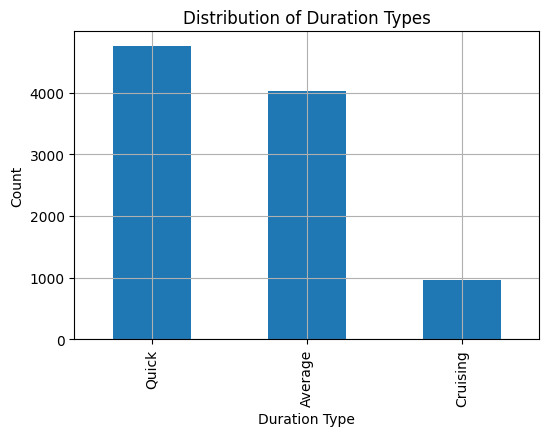

In [14]:
data['DurationType'].value_counts().plot(kind='bar', figsize=(6,4))
plt.xlabel('Duration Type')
plt.ylabel('Count')
plt.title('Distribution of Duration Types')
plt.grid(True)
plt.show()


## Classification NN to forecast the anticipated average duration for any given day.

### Split data set

In [15]:
# encoding the y dataset
le = LabelEncoder()
data['DurationLabel'] = le.fit_transform(data['DurationType'])


In [16]:
data.head()

,Date,BikeType,TripType,AvgDuration,NumTrips,AvgHumidity,MinTemp,MaxTemp,Windy,Rain,Snow,year,month,day_of_week,DurationType,DurationLabel
0,2021-11-17,Standard,Round Trip,32,55,67,36.93,64.18,0,0,0,2021,11,2,Average,0
1,2019-01-30,Standard,Round Trip,33,22,64,11.79,37.98,0,1,1,2019,1,2,Average,0
2,2019-11-11,Standard,Round Trip,36,67,67,35.91,65.48,0,0,0,2019,11,0,Average,0
3,2022-02-14,Standard,Round Trip,17,23,53,15.30,32.68,0,0,0,2022,2,0,Quick,2
4,2020-06-11,Electric,Round Trip,78,74,81,72.91,85.19,0,1,0,2020,6,3,Cruising,1


In [17]:
# Define features (exclude NumTrips and target-related columns)
X = data.drop(columns=['NumTrips', 'AvgDuration', 'DurationType', 'DurationLabel'])

# Define target
y = data['DurationLabel']  # this is  0/1/2 label column

# Do a stratified split to preserve class balance in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
X_train_0 = X_train.copy()
X_test_0 = X_test.copy()
y_train_0 = y_train.copy()
y_test_0 = y_test.copy()

### Prepare the data

In [18]:
cat_attribs = ['BikeType', 'TripType', 'month', 'day_of_week']
num_attribs = list(X_train.drop(columns=cat_attribs, axis=1))
print(num_attribs)

['Date', 'AvgHumidity', 'MinTemp', 'MaxTemp', 'Windy', 'Rain', 'Snow', 'year']


How do we handle date? Assuming ordianl for now

In [19]:
# categorical attributes for this data set
cat_attribs = ['BikeType', 'TripType', 'month', 'day_of_week']

# ordinal attribute (no scaling, but median imputation)
ord_attribs = ['year']

# scaled numerical attributes (for neural networks)
num_attribs = [ 'AvgHumidity', 'MinTemp',
               'MaxTemp', 'Windy', 'Rain', 'Snow']

# define pipeline for scaled numeric attributes
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('minmax_scaler', MinMaxScaler()),
])

# define pipeline for ordinal numeric attributes (no scaling)
ord_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median"))
])

# define the pipeline process for the dataset
col_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('ord', ord_pipeline, ord_attribs),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)
])

# build a top-level pipeline that in the future will allow for more sophisticated data preparation steps including other ML models
full_pipeline = Pipeline([
    ('col_pipeline', col_pipeline),
])
full_pipeline_2=SPL([
    ('col_pipeline', col_pipeline),
    ('smote', SMOTE(random_state=42))
])

In [20]:
#create an array of prepared data based on the training data set
X_train = full_pipeline.fit_transform( X_train)
X_test = full_pipeline.transform(X_test )

X_train.shape, X_test.shape

((7800, 30), (1950, 30))

In [21]:
X_train_resampled, y_train_resampled = full_pipeline_2.fit_resample(X_train_0, y_train_0)

# Check the result
print("Original shape:", X_train.shape, y_train.value_counts().to_dict())
print("Resampled shape:", X_train_resampled.shape, dict(pd.Series(y_train_resampled).value_counts()))
y_train_resampled_cat = to_categorical(y_train_resampled)

Original shape: (7800, 30) {2: 3804, 0: 3228, 1: 768}
Resampled shape: (11412, 30) {2: np.int64(3804), 0: np.int64(3804), 1: np.int64(3804)}


In [22]:
# making sure y is encoded
y_train.shape, y_test.shape
print(y_train)
print(y_test)

4145    2
8590    0
4463    2
6096    0
3120    0
       ..
4253    2
5915    2
7538    2
2216    2
1959    0
Name: DurationLabel, Length: 7800, dtype: int64
7905    1
1880    0
587     0
160     0
6140    0
       ..
6934    0
5663    2
6841    0
1283    2
9066    0
Name: DurationLabel, Length: 1950, dtype: int64


### Prepare the data

In [23]:
# Encoding Y values for keras
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


### Create a Baseline Prediction

Is this the correct way?

In [24]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
baseline_predictions = dummy_clf.predict(X_test)
#Calculate naive accuracy
naive_accuracy = accuracy_score(y_test, baseline_predictions)
print(f'Naive CLASSIFICATION accuracy (most frequent) on test set: {naive_accuracy:.4f}')
print("Classification Report (Baseline) on test set:")
print(classification_report(y_test, baseline_predictions,
                            target_names=le.classes_))

Naive CLASSIFICATION accuracy (most frequent) on test set: 0.4877
Classification Report (Baseline) on test set:
              precision    recall  f1-score   support

     Average       0.00      0.00      0.00       807
    Cruising       0.00      0.00      0.00       192
       Quick       0.49      1.00      0.66       951

    accuracy                           0.49      1950
   macro avg       0.16      0.33      0.22      1950
weighted avg       0.24      0.49      0.32      1950



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Build the Neural Network, Compile & Train

In [25]:
#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

#set seed values for neural network
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
keras.utils.set_random_seed(seed_value)

In [26]:
#the same steps above can be built and saved in a single command with the same results
model = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(3, activation="softmax")
])

In [27]:
#After model is created, it needs to be compiled - this requires setting
#the loss function to mean_squared_error
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=.00001),
              metrics=["accuracy"]
             )

In [28]:
#fit the model and capture the details of the fit to a variable called history
#note that validation data is dynamically allocated at 20% of the training data
early_stopping = keras.callbacks.EarlyStopping('val_loss', patience=10)
history = model.fit(X_train,
                    y_train_cat,
                    batch_size=128,
                    epochs=1000,
                    shuffle = True,
                    validation_split=.2,
                    callbacks=[early_stopping]
                   )

Epoch 1/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.4855 - loss: 55.8300 - val_accuracy: 0.4942 - val_loss: 50.7438
Epoch 2/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4855 - loss: 50.2666 - val_accuracy: 0.4942 - val_loss: 45.3246
Epoch 3/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4855 - loss: 44.7497 - val_accuracy: 0.4942 - val_loss: 39.9293
Epoch 4/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4855 - loss: 39.2556 - val_accuracy: 0.4942 - val_loss: 34.5540
Epoch 5/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4855 - loss: 33.7811 - val_accuracy: 0.4942 - val_loss: 29.1960
Epoch 6/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4855 - loss: 28.3236 - val_accuracy: 0.4942 - val_loss: 23.8529
Epoch 7/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4855 - loss: 22.8807 - val_accuracy: 0.4942 - val_loss: 18.5223
Epoch 8/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4855 - loss: 17.

### Evaluate Performance

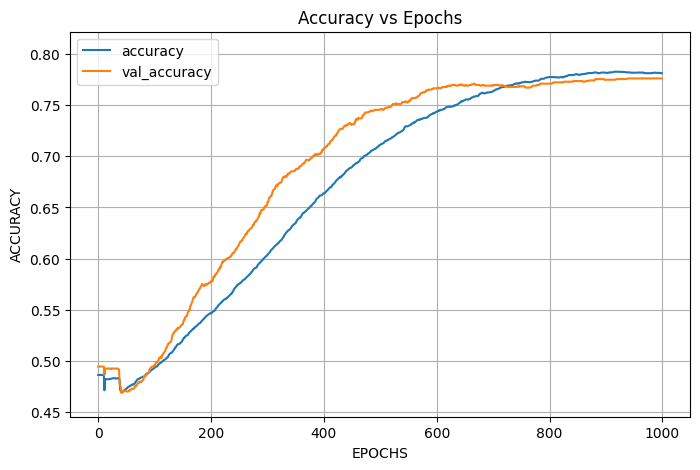

In [29]:
#plot the loss learning curve
nn_plot_learning_curve_2(history)

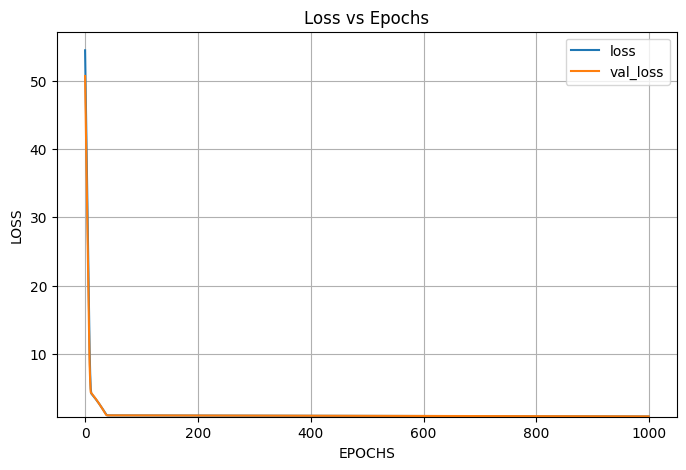

In [30]:
nn_plot_learning_curve_3(history)

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,381 (21.02 KB)

 Trainable params: 1,793 (7.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,588 (14.02 KB)

In [32]:
# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # predicted class index

# True Labels (convert from probablities back to class index)
y_true = np.argmax(y_test_cat, axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Classification Report:
              precision    recall  f1-score   support

     Average       0.72      0.85      0.78       807
    Cruising       0.00      0.00      0.00       192
       Quick       0.87      0.90      0.88       951

    accuracy                           0.79      1950
   macro avg       0.53      0.58      0.55      1950
weighted avg       0.72      0.79      0.75      1950

Confusion Matrix:
[[685   0 122]
 [181   0  11]
 [ 92   0 859]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


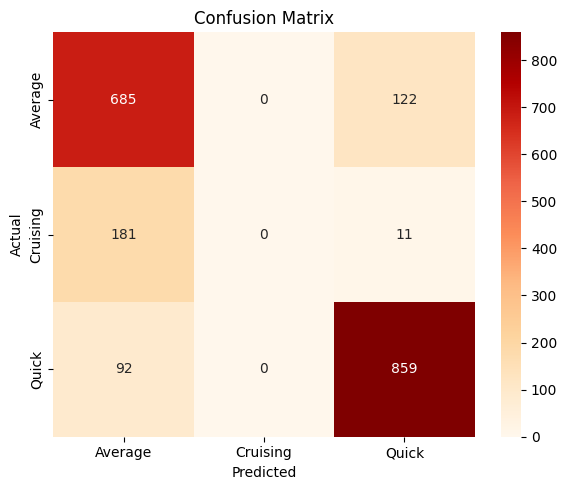

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Optional: define class names
class_names = le.classes_  #

# Plot with seaborn for a nicer look
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [34]:
#evaluate model loss metric on the Test set
loss, acc = model.evaluate(X_test, y_test_cat)
print( f"Accuracy: {acc:,.4f}" )

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8037 - loss: 0.7668
Accuracy: 0.7918


In [35]:
y_pred_train = model.predict(X_train)
y_pred_train_labels = y_pred_train.argmax(axis=1)
train_accuracy = accuracy_score(y_train, y_pred_train_labels)
print(f"Training Accuracy: {train_accuracy:.4f}")

print("Classification Report (Train):")
print(classification_report(y_train, y_pred_train_labels, target_names=le.classes_))

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training Accuracy: 0.7827
Classification Report (Train):
              precision    recall  f1-score   support

     Average       0.70      0.84      0.77      3228
    Cruising       0.00      0.00      0.00       768
       Quick       0.86      0.89      0.88      3804

    accuracy                           0.78      7800
   macro avg       0.52      0.58      0.55      7800
weighted avg       0.71      0.78      0.74      7800



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
y_pred_test = model.predict(X_test)
y_pred_test_labels = y_pred_test.argmax(axis=1)
test_accuracy = accuracy_score(y_test, y_pred_test_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report (Test):")
print(classification_report(y_test, y_pred_test_labels, target_names=le.classes_))


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Accuracy: 0.7918
Classification Report (Test):
              precision    recall  f1-score   support

     Average       0.72      0.85      0.78       807
    Cruising       0.00      0.00      0.00       192
       Quick       0.87      0.90      0.88       951

    accuracy                           0.79      1950
   macro avg       0.53      0.58      0.55      1950
weighted avg       0.72      0.79      0.75      1950



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
# Print the first 5 test cases (classification)
for x in range(5):
    actual_label = le.inverse_transform([y_test.iloc[x]])[0]
    predicted_label = le.inverse_transform([y_pred_test_labels[x]])[0]
    print(f"Actual: {actual_label:<10} --- Prediction: {predicted_label:<10}")


Actual: Cruising   --- Prediction: Average   
Actual: Average    --- Prediction: Quick     
Actual: Average    --- Prediction: Quick     
Actual: Average    --- Prediction: Average   
Actual: Average    --- Prediction: Average   


## Building Classifier on oversampled data using Smote

In [38]:
#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

#set seed values for neural network
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
keras.utils.set_random_seed(seed_value)

In [39]:
#the same steps above can be built and saved in a single command with the same results
model_os = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(3, activation="softmax")
])

In [40]:
#After model is created, it needs to be compiled - this requires setting
#the loss function to mean_squared_error
model_os.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=.00001),
              metrics=["accuracy"]
             )

Model with SMOTE

In [41]:
#fit the model and capture the details of the fit to a variable called history
#note that validation data is dynamically allocated at 20% of the training data
early_stopping = keras.callbacks.EarlyStopping('loss', patience=10)
history_os = model_os.fit(X_train_resampled,
                    y_train_resampled_cat,
                    batch_size=32,
                    epochs=500,
                    shuffle = True,
                    # validation_split=.2,
                    callbacks=[early_stopping]
                   )

Epoch 1/500
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3255 - loss: 59.4821
Epoch 2/500
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3255 - loss: 19.5261
Epoch 3/500
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3255 - loss: 9.3967
Epoch 4/500
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3255 - loss: 4.5994
Epoch 5/500
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3034 - loss: 1.1195
Epoch 6/500
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3314 - loss: 1.1052
Epoch 7/500
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3330 - loss: 1.1049
Epoch 8/500
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3326 - loss: 1.1046
Epoch 9/500
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3312 - loss: 1.1042
Epoch 10/500
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3307 - loss: 1.1038
Epoch 11/500
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3350 - loss: 1.1034
Epoch 12/500
357/357 ━━━━━━━━━━━━━━━━━━

In [42]:
#Get Predictions
y_pred_probs = model_os.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # predicted class index

#True Labels (convert from probs back to class index)
y_true = np.argmax(y_test_cat, axis=1)

#Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

#Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

     Average       0.74      0.66      0.70       807
    Cruising       0.31      0.40      0.35       192
       Quick       0.87      0.90      0.89       951

    accuracy                           0.75      1950
   macro avg       0.64      0.65      0.64      1950
weighted avg       0.76      0.75      0.75      1950

Confusion Matrix:
[[530 157 120]
 [107  76   9]
 [ 79  13 859]]


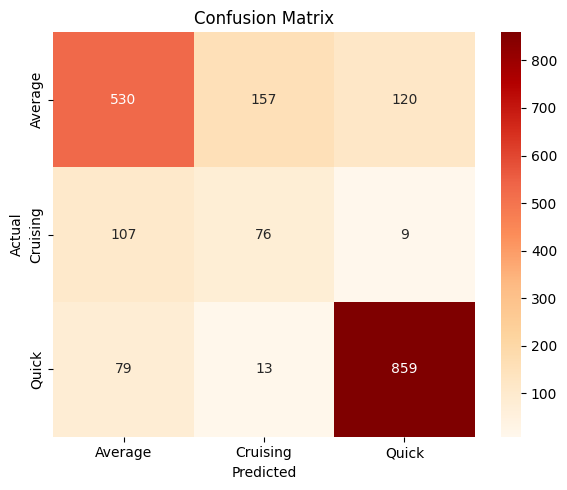

In [43]:
cm = confusion_matrix(y_true, y_pred)

#define class names
class_names = le.classes_  #

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## <font color=Blue>Hyperparameter Tuning - Classification Model

In [44]:
#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

#set seed values for neural network
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
keras.utils.set_random_seed(seed_value)

### Define Regression Model & Design Options (layers & hyperparameters)

In [45]:
def reg_model_builder(hp):

    #select an optimizer and learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0001, 0.00001])#values=[.01,.001,.0001])
    optimizer = hp.Choice("optimizer", values=["adam","sgd"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)

    #choose the number of neurons (i.e. the number of units)
    hp_units = hp.Int('units', min_value=10, max_value=50, step=10)

    #choose the number of layers
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=5, default=2)

    #build the model
    model = keras.Sequential()

    #first layer
    model.add(keras.layers.Flatten())
    #hidden layers
    for _ in range(n_hidden):
        model.add(keras.layers.Dense(units=hp_units, activation='relu'))

    #last layer
    model.add(keras.layers.Dense(3, activation="softmax"))

    #compile the model
    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

### Create a Hyperband Tuning Object

In [46]:
tuner = kt.Hyperband(reg_model_builder,
                     objective='val_accuracy',
                     max_epochs=100,                   #increase for more trials (but will take longer)
                     overwrite=True,                  #change to False and model will continue to learn from previous runs
                     hyperband_iterations=3,
                     seed=42,
                     project_name="Indego"  #a local directory with this name will be created (houses log files)
                     )


In [47]:
#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

#set seed values for neural network
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
keras.utils.set_random_seed(seed_value)
# Search for the best performing models
early_stopping = keras.callbacks.EarlyStopping('val_loss', patience=3)
tuner.search(X_train, y_train_cat,
             epochs=500,
             validation_split=0.2,
             callbacks=[early_stopping]
             )

Trial 177 Complete [00h 00m 06s]
val_accuracy: 0.4942307770252228

Best val_accuracy So Far: 0.778205156326294
Total elapsed time: 00h 17m 38s


In [48]:
# Get the optimal hyperparameters
best_params=tuner.get_best_hyperparameters(num_trials=1)[0]
best_params.values

{'learning_rate': 0.001,
 'optimizer': 'adam',
 'units': 40,
 'n_hidden': 1,
 'tuner/epochs': 12,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 4,
 'tuner/round': 2,
 'tuner/trial_id': '0105'}

In [49]:
#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

#set seed values for neural network
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
keras.utils.set_random_seed(seed_value)
#build the best model based on these parameters
best_model = reg_model_builder(best_params)


In [50]:
#fit the data to the best model & its parameters
early_stopping = keras.callbacks.EarlyStopping('val_loss', patience=20)
history=best_model.fit(X_train, y_train_cat,
             epochs=500,
             validation_split=0.2,
             callbacks=[early_stopping]
             )

Epoch 1/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4366 - loss: 67.6176 - val_accuracy: 0.4942 - val_loss: 1.1453
Epoch 2/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6060 - loss: 0.9605 - val_accuracy: 0.6891 - val_loss: 0.8322
Epoch 3/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6988 - loss: 0.8382 - val_accuracy: 0.7769 - val_loss: 0.6929
Epoch 4/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7252 - loss: 0.7803 - val_accuracy: 0.7763 - val_loss: 0.6437
Epoch 5/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7374 - loss: 0.7634 - val_accuracy: 0.7750 - val_loss: 0.6298
Epoch 6/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7311 - loss: 0.7815 - val_accuracy: 0.7750 - val_loss: 0.6186
Epoch 7/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7288 - loss: 0.7682 - val_accuracy: 0.7750 - val_loss: 0.6201
Epoch 8/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7385 - loss: 0.7556 - val_acc

In [51]:
#review the model
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (32, 30)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 40)               │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           123 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,091 (15.98 KB)

 Trainable params: 1,363 (5.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,728 (10.66 KB)

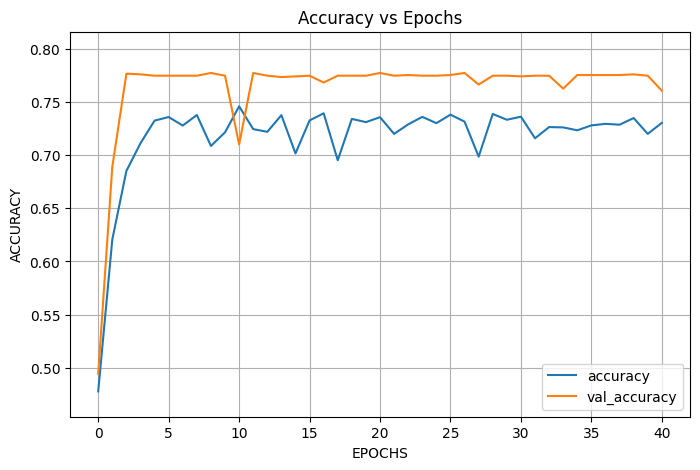

In [52]:
#plot the model's learning curve
nn_plot_learning_curve_2(history)

In [53]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

### Evaluate the Optimal Model

In [54]:
#evaluate Training Data
train_loss, train_accuracy = best_model.evaluate(X_train, y_train_cat)
print(f"Training Accuracy: {train_accuracy:.4f}")

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7636 - loss: 0.7174
Training Accuracy: 0.7646


In [55]:
#evaluate Test Data
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {test_accuracy:.4f}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7931 - loss: 0.6728
Test Accuracy: 0.7790


In [56]:
#predict the Training lables
y_pred_train = best_model.predict(X_train)
y_pred_train_labels = y_pred_train.argmax(axis=1)

# Compare with actual
print("Classification Report (Train):")
print(classification_report(y_train, y_pred_train_labels, target_names=le.classes_))


244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report (Train):
              precision    recall  f1-score   support

     Average       0.71      0.76      0.73      3228
    Cruising       0.50      0.00      0.00       768
       Quick       0.81      0.92      0.86      3804

    accuracy                           0.76      7800
   macro avg       0.67      0.56      0.53      7800
weighted avg       0.74      0.76      0.72      7800



In [57]:
# Predict the test data set
y_pred = best_model.predict(X_test)

# Convert softmax probabilities to class labels
y_pred_labels = y_pred.argmax(axis=1)

# Evaluate accuracy
test_accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Compare with actual
print("Classification Report (Test):")
print(classification_report(y_test, y_pred_labels, target_names=le.classes_))

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Accuracy: 0.7790
Classification Report (Test):
              precision    recall  f1-score   support

     Average       0.73      0.78      0.76       807
    Cruising       1.00      0.01      0.01       192
       Quick       0.82      0.93      0.87       951

    accuracy                           0.78      1950
   macro avg       0.85      0.57      0.55      1950
weighted avg       0.80      0.78      0.74      1950



In [58]:
# Print first 5 test cases (classification)
for x in range(5):
    actual_label = le.inverse_transform([y_test.iloc[x]])[0]
    predicted_label = le.inverse_transform([y_pred_labels[x]])[0]
    print(f"Actual: {actual_label:<10} --- Prediction: {predicted_label:<10}")


Actual: Cruising   --- Prediction: Average   
Actual: Average    --- Prediction: Quick     
Actual: Average    --- Prediction: Quick     
Actual: Average    --- Prediction: Average   
Actual: Average    --- Prediction: Quick     


## Predict a number of trips for the new test dataset





In [59]:
# retrive the IndegoRidesToPredict.csv file and create pred_data
path = "https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/main/chpt10/"
filename = "IndegoRidesToPredict.csv"
downloadDataResource(filename, path)
pred_data = pd.read_csv(filename)
pred_data.head()

Downloaded IndegoRidesToPredict.csv


,Date,BikeType,TripType,AvgHumidity,MinTemp,MaxTemp,Windy,Rain,Snow
0,2020-02-01,Standard,One Way,89,35.10,46.29,0,1,0
1,2020-07-20,Standard,One Way,65,78.06,97.99,0,0,0
2,2022-02-12,Standard,Round Trip,44,44.91,60.69,0,0,0
3,2020-06-08,Standard,One Way,42,55.98,82.69,0,0,0
4,2019-08-26,Electric,One Way,70,58.28,76.48,0,0,0


In [60]:
# Repeating the same feauture enginerring
pred_data['Date'] = pd.to_datetime(pred_data['Date'])

pred_data['year'] = pred_data['Date'].dt.year
pred_data['month'] = pred_data['Date'].dt.month
pred_data['day_of_week'] = pred_data['Date'].dt.dayofweek

#X_pred_raw = pred_data.copy()  # copy just in clase

X_example = full_pipeline.transform(pred_data)  # Shape: (5, num_features)
print(pred_data.shape)
print(X_example.shape)

(5, 12)
(5, 30)


### Prediction Using the optimal model found by tuner

In [61]:
# Predict the duration type class for the new dates
y_pred_probs = best_model.predict(X_example)

# Convert softmax probabilities to class labels
y_pred_classes = y_pred_probs.argmax(axis=1)

# Decode predicted labels to readable class names
pred_labels = le.inverse_transform(y_pred_classes)

# Print predictions
print("Predicted Labels:", pred_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
Predicted Labels: ['Quick' 'Quick' 'Average' 'Quick' 'Quick']


In [62]:
# Print each date with its predicted duration category
for i in range(len(pred_labels)):
    date_str = pred_data.loc[i, 'Date'].strftime('%Y-%m-%d')
    print(f"Prediction for {date_str}: {pred_labels[i]} ")


Prediction for 2020-02-01: Quick 
Prediction for 2020-07-20: Quick 
Prediction for 2022-02-12: Average 
Prediction for 2020-06-08: Quick 
Prediction for 2019-08-26: Quick 


### Prediction Using the model trained on oversampled dataset (using smote)


In [63]:
# Predict the duration type class for the new dates using the model trained on oversampled dataset
y_pred_probs_os = model_os.predict(X_example)

# Convert softmax probabilities to class labels
y_pred_classes_os = y_pred_probs_os.argmax(axis=1)

# Decode predicted labels to readable class names
pred_labels_os = le.inverse_transform(y_pred_classes_os)

# Print predictions
print("Predicted Labels using the model trained on oversampled data:", pred_labels_os)
# Print each date with its predicted duration category
for i in range(len(pred_labels_os)):
    date_str = pred_data.loc[i, 'Date'].strftime('%Y-%m-%d')
    print(f"Prediction for {date_str}: {pred_labels_os[i]} ")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
Predicted Labels using the model trained on oversampled data: ['Quick' 'Quick' 'Average' 'Quick' 'Quick']
Prediction for 2020-02-01: Quick 
Prediction for 2020-07-20: Quick 
Prediction for 2022-02-12: Average 
Prediction for 2020-06-08: Quick 
Prediction for 2019-08-26: Quick 


### Prediction Using the original model trained on original dataset





In [64]:
# Predict the duration type class for the new dates using the model trained on oversampled dataset
y_pred_probs_og = model.predict(X_example)

# Convert softmax probabilities to class labels
y_pred_classes_og = y_pred_probs_og.argmax(axis=1)

# Decode predicted labels to readable class names
pred_labels_og = le.inverse_transform(y_pred_classes_og)

# Print predictions
print("Predicted Labels using the model trained on oversampled data:", pred_labels_os)
# Print each date with its predicted duration category
for i in range(len(pred_labels_og)):
    date_str = pred_data.loc[i, 'Date'].strftime('%Y-%m-%d')
    print(f"Prediction for {date_str}: {pred_labels_og[i]} ")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Predicted Labels using the model trained on oversampled data: ['Quick' 'Quick' 'Average' 'Quick' 'Quick']
Prediction for 2020-02-01: Quick 
Prediction for 2020-07-20: Quick 
Prediction for 2022-02-12: Average 
Prediction for 2020-06-08: Quick 
Prediction for 2019-08-26: Quick 
